In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import *
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.set_device(1)

In [3]:
def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions, reconstruction ,primary_caps_output, digit_caps_output, c, b = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    plt.show()

In [4]:
def squash(x, dim=-1):
    suqared_norm = (x ** 2 ).sum(dim=dim, keepdim=True)
    scale = suqared_norm / (1 + suqared_norm)
    return scale * (x / suqared_norm.sqrt() + 1e-8)


# class PrimaryCaps(nn.Module):
#     def __init__(self, num_conv_units, in_channels, out_channels, kernel_size, stride):  
#         super(PrimaryCaps, self).__init__()
#         self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels * num_conv_units,
#                               kernel_size=kernel_size, stride=stride)
        
#         self.out_channels = out_channels

#     def forward(self, x):
#         out = self.conv(x) 
#         batch_size = out.shape[0] 
#         return squash(out.contiguous().view(batch_size, -1, self.out_channels), dim=-1) 
# Input: [Batch_Size, 256, 20, 20] Output: [Batch_Size, 1152, 8]
class PrimaryCaps(nn.Module):
    def __init__(self, num_conv_units, in_channels, out_channels, kernel_size, stride):
        super(PrimaryCaps, self).__init__()
        self.num_conv_units = num_conv_units
        input_features = 20 * 20 * in_channels 
        output_features = 6 * 6 * out_channels * num_conv_units  
        self.fc = nn.Linear(input_features, output_features)
        self.out_channels = out_channels

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1) 
        out = self.fc(x)
        out = out.view(batch_size, 6 * 6 * self.num_conv_units, -1)
        return squash(out, dim=-1)



class DigitCaps(nn.Module):
    def __init__(self, in_dim, in_caps, num_caps, dim_caps, num_routing, device):
        super(DigitCaps, self).__init__()
        self.in_dim = in_dim
        self.in_caps = in_caps
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.num_routing = num_routing
        self.device = device
        self.W = nn.Parameter(0.01 * torch.randn(1, num_caps, in_caps, dim_caps, in_dim),
                              requires_grad=True)


    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1).unsqueeze(4)
        u_hat = torch.matmul(self.W, x)
        u_hat = u_hat.squeeze(-1)
        temp_u_hat = u_hat.detach()
        b = torch.zeros(batch_size, self.num_caps, self.in_caps, 1).to(self.device)
        for route_iter in range(self.num_routing - 1):
            c = b.softmax(dim=1)
            s = (c * temp_u_hat).sum(dim=2)
            v = squash(s)
            uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
            b += uv
        c = b.softmax(dim=1)
        s = (c * u_hat).sum(dim=2)
        v = squash(s)

        return v, c, b

class CapsNet(nn.Module):
    def __init__(self, device):
        super(CapsNet, self).__init__()
        self.device = device
        self.conv = nn.Conv2d(1, 256, 9) # 28 * 28 → 20 * 20
        self.relu = nn.ReLU(inplace=True)
        self.primary_caps = PrimaryCaps(num_conv_units=32,       
                                        in_channels=256,
                                        out_channels=8,
                                        kernel_size=9,
                                        stride=2)            
        self.digit_caps = DigitCaps(in_dim=8,
                                    in_caps=32 * 6 * 6,
                                    num_caps=10,
                                    dim_caps=16,
                                    num_routing=3,
                                    device=device)  
        self.decoder = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid())

    def forward(self, x):
        out = self.relu(self.conv(x)) 
        out = self.primary_caps(out) 
        primary_caps_output = out
        out, c, b = self.digit_caps(primary_caps_output)
        digit_caps_output = out
        logits = torch.norm(digit_caps_output, dim=-1)
        pred = torch.eye(10).to(self.device).index_select(dim=0, index=torch.argmax(logits, dim=1))
        batch_size = out.shape[0]
        reconstruction = self.decoder((out * pred.unsqueeze(2)).contiguous().view(batch_size, -1))
        return logits, reconstruction, primary_caps_output, digit_caps_output, c, b

In [ ]:
args = get_args.get_arg()
data_dir = './data/fashion'
sigma = 0.5
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = CapsNet(device=device)
global_model.load_state_dict(torch.load(f'./checkpoints/Capsule/fashion/common/best_model_fashion.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
ind = 4
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b= global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

Noise: 0, Ground Truth: 6, Noised Result: 6
Noise: 0.5, Ground Truth: 6, Noised Result: 6
Noise: 1, Ground Truth: 6, Noised Result: 6
Noise: 1.5, Ground Truth: 6, Noised Result: 6
Noise: 2.0, Ground Truth: 6, Noised Result: 6
Noise: 2.5, Ground Truth: 6, Noised Result: 6
Noise: 3.0, Ground Truth: 6, Noised Result: 6
Noise: 3.5, Ground Truth: 6, Noised Result: 6
Noise: 4.0, Ground Truth: 6, Noised Result: 6
Noise: 4.5, Ground Truth: 6, Noised Result: 8
Noise: 5.0, Ground Truth: 6, Noised Result: 8


In [6]:
def forward_logits_only(input_data):
    return global_model(input_data)[0]

In [7]:
saliency = Saliency(forward_logits_only)
ig = IntegratedGradients(forward_logits_only)
dl = DeepLift(forward_logits_only)
nt = NoiseTunnel(ig)
print('-------------------')
print('Original Image')
print('Predicted:', classes[predicted_classes],
      ' Probability:', torch.max(F.softmax(ground_truth_predictions, 1)).item())


-------------------
Original Image
Predicted: Shirt  Probability: 0.1919926106929779


In [8]:
def visualization(noise_scale, model, input):
    avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise_scale, model, input, 100)
    global_model.zero_grad()
    tensor_attributions = ig.attribute(input, 
                                   target=labels[ind], 
                                   baselines=avg_noisy_image * 0, 
                                   n_steps=1000, 
                                   return_convergence_delta=True)
    attr_ig, delta = tensor_attributions
    tensor_28x28 = attr_ig.squeeze().cpu().detach().reshape(28, 28)
    attr_ig = np.transpose(tensor_28x28.detach().numpy(), (1, 0))
    print('-------------------')
    print('Smoothing Image')
    print('Predicted:', classes[prediction], ' Probability:', torch.max(F.softmax(predictions, 1)).item())
    attr_ig = attr_ig[:, :, np.newaxis]
    avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
    _, axis = viz.visualize_image_attr(attr_ig, avg_noisy_np, method="masked_image", sign="positive",
                              show_colorbar=True, title="Overlayed Integrated Gradients", use_pyplot=True)

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.19220227003097534


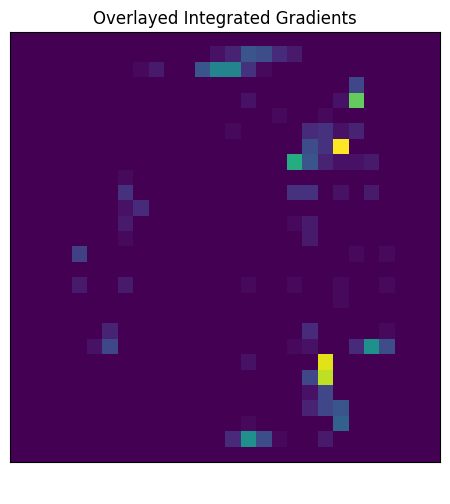

In [9]:
visualization(noise_scale=0.001, model=global_model, input=input)

In [10]:
def test_capsule(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        # Add channels = 1
        images = images.to(device)
        # Categogrical encoding
        labels = torch.eye(10).index_select(dim=0, index=labels).to(device)
        logits, reconstructions, primary_caps_output, digit_caps_output, c, b = model(images)
        pred_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(pred_labels == torch.argmax(labels, dim=1)).item()
        total += len(labels)

    print('Accuracy: {}'.format(correct / total))

In [11]:
test_capsule(global_model, device, test_loader)
test_capsule(global_model, device, train_loader)

Accuracy: 0.9203
Accuracy: 0.9958166666666667


In [12]:
def visual_images(model, index):
    input = images[index].unsqueeze(0)
    label = labels[index]
    input.requires_grad = True
    model.eval()
    ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(input)
    _, predicted_class_index = torch.max(ground_truth_predictions, 1)
    is_correct = (predicted_class_index == labels[index]).item()
    original_image = images[index].view(28, 28).cpu().detach().numpy()
    reconstructed_image = reconstruction.view(28, 28).cpu().detach().numpy()
    actual_class = classes[labels[index].item()]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image - " + actual_class)
    axes[0].axis('off')  # 关闭坐标轴
    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Image" + (" - Correct" if is_correct else " - Incorrect"))
    axes[1].axis('off')  # 关闭坐标轴

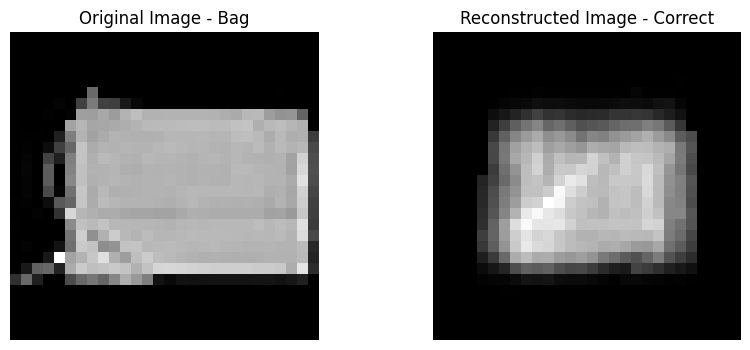

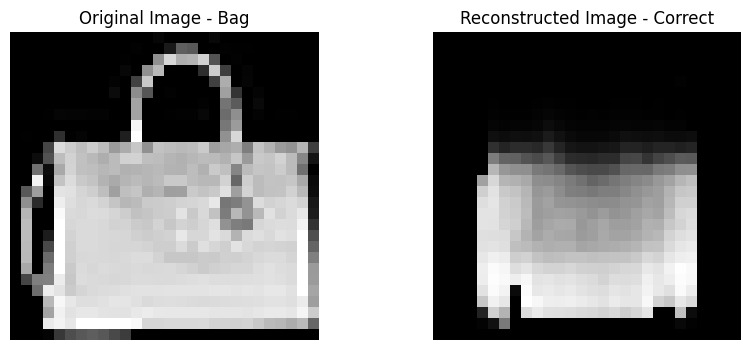

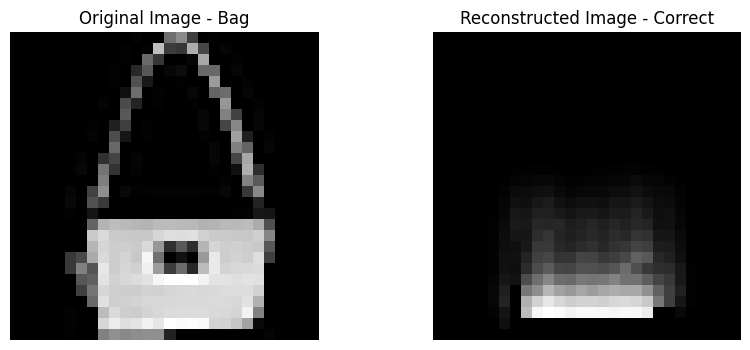

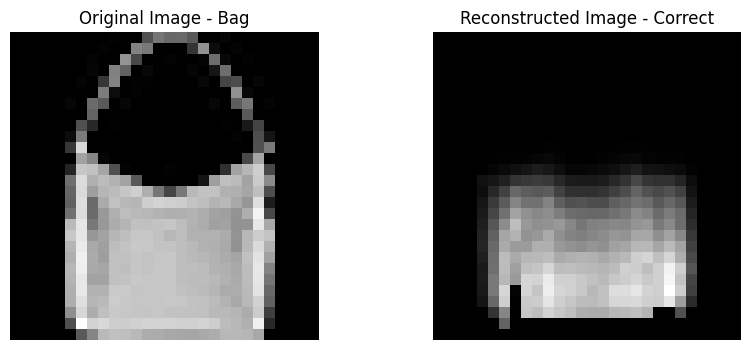

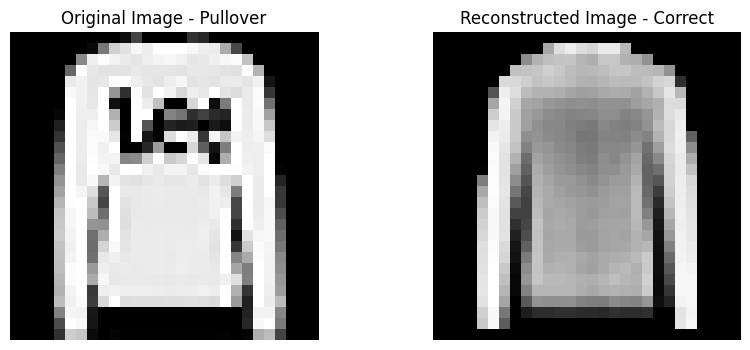

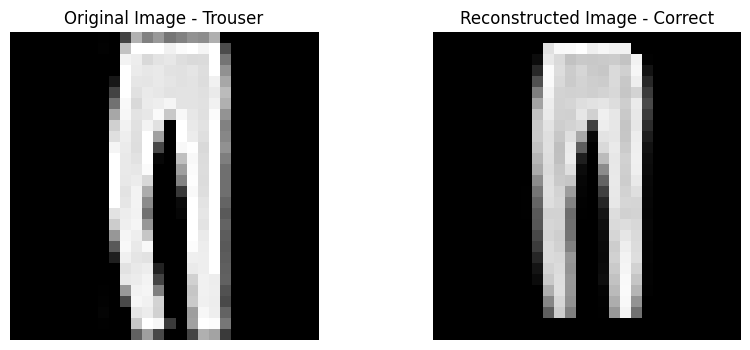

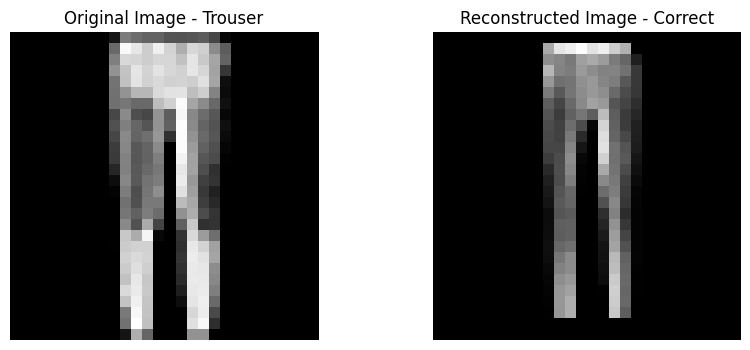

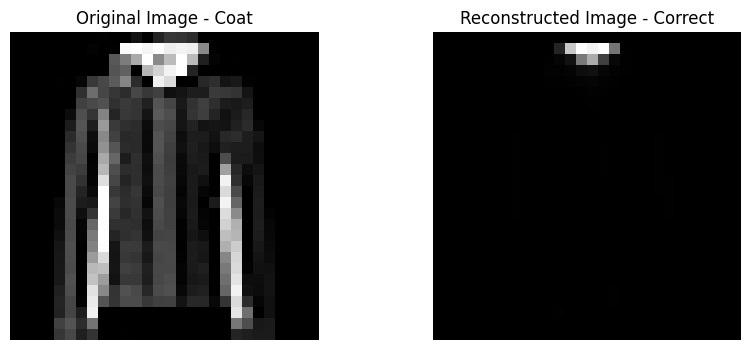

In [13]:
visual_images(global_model, 18)
visual_images(global_model, 30)
visual_images(global_model, 31)
visual_images(global_model, 34)
visual_images(global_model, 1)
visual_images(global_model, 2)
visual_images(global_model, 3)
visual_images(global_model, 6)

In [14]:
label_list = list()
for i, label in enumerate(labels):
    label_list.append(f'{i}: {classes[label]}')

In [15]:
def visual_images2(model, index):
    input = images[index].unsqueeze(0)
    label = labels[index]
    input.requires_grad = True
    model.eval()
    ground_truth_predictions, reconstruction , primary_caps_output, digit_caps_output, c, b= model(input)
    _, predicted_class_index = torch.max(ground_truth_predictions, 1)
    print('--------------------')
    print(f'The size of primary caps is {primary_caps_output.size()}')
    print(f'The size of digit caps is {digit_caps_output.size()}')
    print('--------------------')
    print(f'The size of c is {c.size()}')
    print(f'The size of b is {b.size()}')
    return primary_caps_output, digit_caps_output, c, b
def visualize_digit_caps_output(digit_caps_output):
    caps_sizes = np.linalg.norm(digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
    plt.bar(range(len(caps_sizes)), caps_sizes)
    plt.xlabel('Capsule')
    plt.ylabel('Size')
    plt.title('Sizes of Digit Capsules')
    plt.show()
def visualize_top_n_primary_caps_for_digit_caps(c, digit_caps_index, top_n, threshold):
    coupling_coeffs = c[0, digit_caps_index].squeeze()
    indices = torch.where(coupling_coeffs > threshold)[0]
    print(indices)
    top_n_indices = coupling_coeffs.topk(top_n).indices
    plt.figure(figsize=(10, 2))
    plt.bar(range(top_n), coupling_coeffs[top_n_indices].cpu().detach().numpy())
    plt.xlabel('Primary Capsule Index')
    plt.ylabel('Coupling Coefficient')
    plt.title(f'Top {top_n} Primary Capsules for Digit Capsule {digit_caps_index}')
    plt.show()
def visualize_top_n(c, digit_caps_index, top_n, threshold):
    coupling_coeffs = c[0, digit_caps_index].squeeze()
    indices = torch.where(coupling_coeffs > threshold)[0]
    print("Indices of primary capsules with coupling coefficients above threshold:", indices)
    top_n_indices = coupling_coeffs.topk(top_n).indices
    print("Top N primary capsules indices:", top_n_indices)
    plt.figure(figsize=(10, 2))
    plt.bar(range(top_n), coupling_coeffs[top_n_indices].cpu().detach().numpy())
    plt.xlabel('Primary Capsule Index')
    plt.ylabel('Coupling Coefficient')
    plt.title(f'Top {top_n} Primary Capsules for Digit Capsule {digit_caps_index}')
    plt.show()
    top_n_indices = list(top_n_indices)
    return top_n_indices
# #-----Select-----
# def modify_primary_caps_output(primary_caps_output, indices):
#     modified_output = torch.zeros_like(primary_caps_output)
#     for index in indices:
#         modified_output[:, index, :] = primary_caps_output[:, index, :]
#     return modified_output
# #-----Reconstruction-----
# def reconstruct_image_with_selected_capsules(model, primary_caps_output, indices):
#     modified_primary_caps_output= modify_primary_caps_output(primary_caps_output, indices)
#     digit_caps_output, c, b = model.digit_caps(modified_primary_caps_output)
#     logits = torch.norm(digit_caps_output, dim=-1)
#     pred = torch.eye(10).to(model.device).index_select(dim=0, index=torch.argmax(logits, dim=1))
#     batch_size = digit_caps_output.shape[0]
#     reconstruction = model.decoder((digit_caps_output * pred.unsqueeze(2)).contiguous().view(batch_size, -1))
#     image_size=(28, 28)
#     image = reconstruction.view(*image_size).cpu().detach().numpy()
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     plt.title(f'Capsule {indices}')
#     plt.show()
#     return reconstruction
def modify_primary_caps_output_removal(primary_caps_output, indices):
    modified_output = primary_caps_output.clone()
    for index in indices:
        modified_output[:, index, :] = 0
    return modified_output

def reconstruct_image_with_removal_selected_capsules(model, primary_caps_output, indices):
    model.eval()
    modified_primary_caps_output = modify_primary_caps_output_removal(primary_caps_output, indices)
    digit_caps_output, c, b = model.digit_caps(modified_primary_caps_output)
    logits = torch.norm(digit_caps_output, dim=-1)
    pred = torch.eye(10).to(model.device).index_select(dim=0, index=torch.argmax(logits, dim=1))
    batch_size = digit_caps_output.shape[0]
    reconstruction = model.decoder((digit_caps_output * pred.unsqueeze(2)).contiguous().view(batch_size, -1))
    image_size = (28, 28)
    image = reconstruction.view(*image_size).cpu().detach().numpy()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    return reconstruction

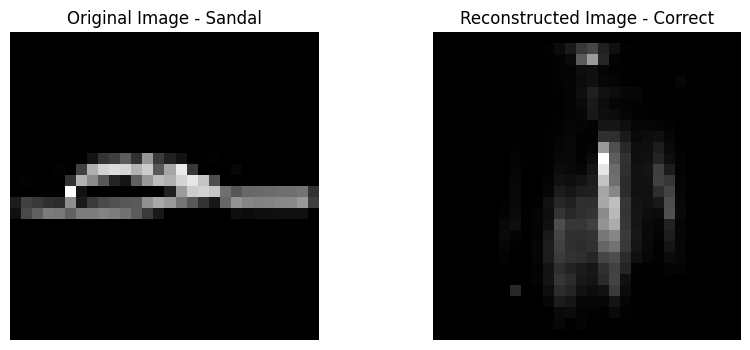

In [23]:
index_new = 8 # 28 18 10 13 15 16 19 9 7 8
visual_images(global_model, index_new)

--------------------
The size of primary caps is torch.Size([1, 1152, 8])
The size of digit caps is torch.Size([1, 10, 16])
--------------------
The size of c is torch.Size([1, 10, 1152, 1])
The size of b is torch.Size([1, 10, 1152, 1])


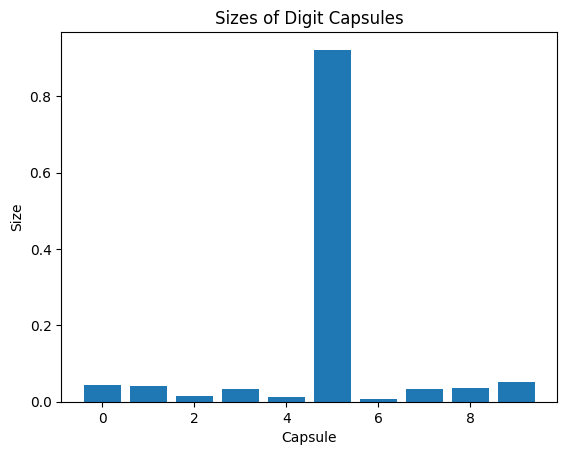

In [24]:
primary_caps_output_new, digit_caps_output_new, c_new, b_new = visual_images2(global_model, index_new)
visualize_digit_caps_output(digit_caps_output_new)

In [26]:
digit_index = 5

Indices of primary capsules with coupling coefficients above threshold: tensor([], device='cuda:1', dtype=torch.int64)
Top N primary capsules indices: tensor([655, 195, 446, 152, 924, 468, 164, 999, 495, 873], device='cuda:1')


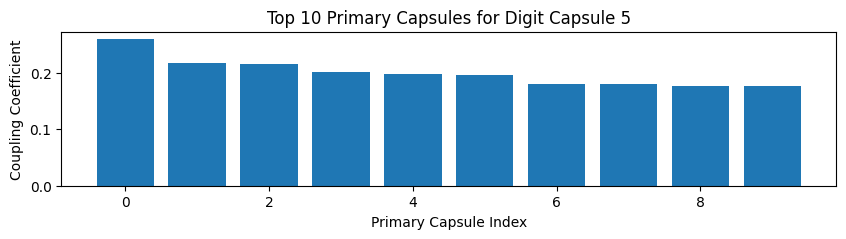

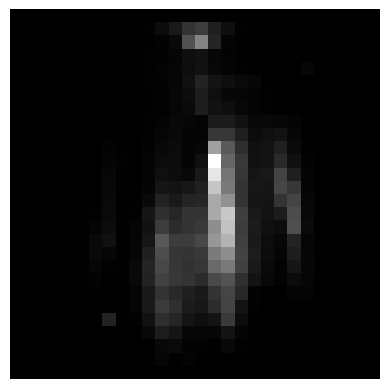

In [27]:
top_n_indices = visualize_top_n(c_new, digit_index, 10, 0.3)
indices_list = [index.cpu().item() if index.is_cuda else index.item() for index in top_n_indices]
reconstruction_new = reconstruct_image_with_removal_selected_capsules(global_model, primary_caps_output_new, indices_list)

Indices of primary capsules with coupling coefficients above threshold: tensor([], device='cuda:1', dtype=torch.int64)
Top N primary capsules indices: tensor([ 655,  195,  446,  152,  924,  468,  164,  999,  495,  873,  904, 1001,
         597,  584,  756,  947,  118,  105,  785,  461,  170,  750,  699,  257,
        1024,  185,  860,  492,  526, 1040], device='cuda:1')


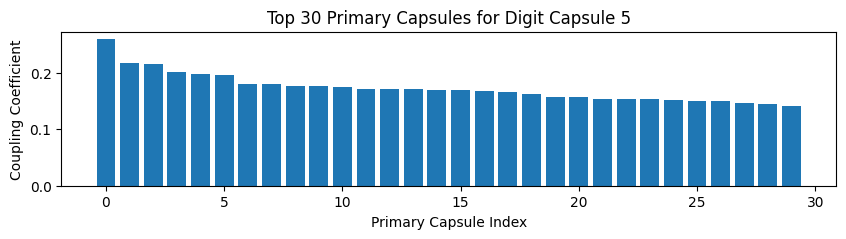

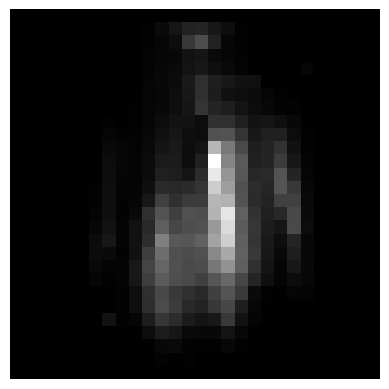

In [28]:
top_n_indices = visualize_top_n(c_new, digit_index, 30, 0.3)
indices_list = [index.cpu().item() if index.is_cuda else index.item() for index in top_n_indices]
reconstruction_new = reconstruct_image_with_removal_selected_capsules(global_model, primary_caps_output_new, indices_list)

Indices of primary capsules with coupling coefficients above threshold: tensor([], device='cuda:1', dtype=torch.int64)
Top N primary capsules indices: tensor([ 655,  195,  446,  152,  924,  468,  164,  999,  495,  873,  904, 1001,
         597,  584,  756,  947,  118,  105,  785,  461,  170,  750,  699,  257,
        1024,  185,  860,  492,  526, 1040,  448,  943,  587,  588, 1015,  783,
         973,  959,  264,  357,  688,  580,  691,  624,  969,  601,  893,  398,
         428,  701], device='cuda:1')


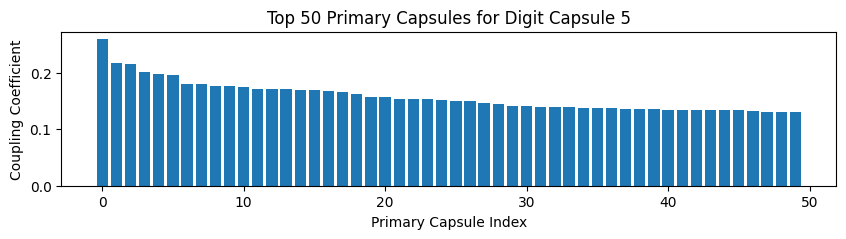

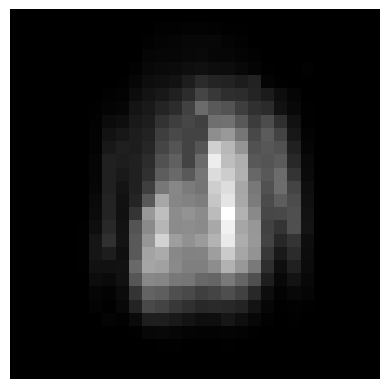

In [29]:
top_n_indices = visualize_top_n(c_new, digit_index, 50, 0.3)
indices_list = [index.cpu().item() if index.is_cuda else index.item() for index in top_n_indices]
reconstruction_new = reconstruct_image_with_removal_selected_capsules(global_model, primary_caps_output_new, indices_list)

Indices of primary capsules with coupling coefficients above threshold: tensor([], device='cuda:1', dtype=torch.int64)
Top N primary capsules indices: tensor([ 655,  195,  446,  152,  924,  468,  164,  999,  495,  873,  904, 1001,
         597,  584,  756,  947,  118,  105,  785,  461,  170,  750,  699,  257,
        1024,  185,  860,  492,  526, 1040,  448,  943,  587,  588, 1015,  783,
         973,  959,  264,  357,  688,  580,  691,  624,  969,  601,  893,  398,
         428,  701,  772,  746,   91,  594,  490, 1086,  628,   33,  149, 1143,
          30,  935,  716,  618,  188,  438,  362,  566, 1075,  634,  366,   97,
         484,  381,  987,  942,  205,  249,  950,   46,  954,  486,  620,  488,
        1101,  845,  471,  536, 1004,  744, 1030,  864,  892,   72,  425,  522,
         826,  599,  364,  839], device='cuda:1')


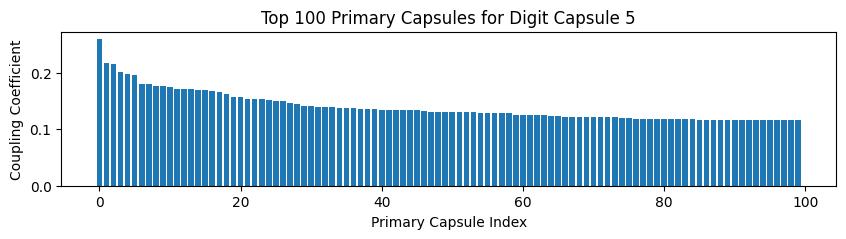

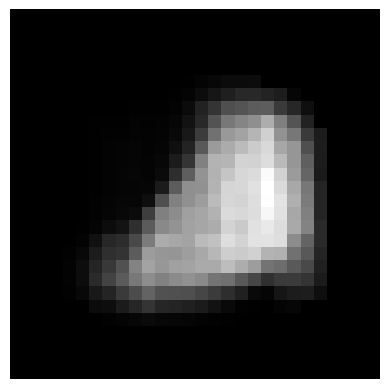

In [30]:
top_n_indices = visualize_top_n(c_new, digit_index, 100, 0.3)
indices_list = [index.cpu().item() if index.is_cuda else index.item() for index in top_n_indices]
reconstruction_new = reconstruct_image_with_removal_selected_capsules(global_model, primary_caps_output_new, indices_list)